In [1]:
!hostname

gpu-69


In [2]:
!which python

/home/jk6373/pyenv/ssml/bin/python


In [3]:
# -*- coding: utf-8 -*-

import os
import re
import json
import pickle
import numpy as np
import pandas as pd
from copy import deepcopy
from glob import glob
from tqdm import tqdm
from collections import OrderedDict
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, classification_report, precision_recall_curve

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import *

np.random.seed(7)
torch.manual_seed(7)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
import torchvision.models as models
resnet18 = models.resnet18()
alexnet = models.alexnet().to(device)
vgg16 = models.vgg16().to(device)
squeezenet = models.squeezenet1_0().to(device)
densenet = models.densenet161().to(device)
inception = models.inception_v3().to(device)

In [5]:
DATA_ROOT = '/beegfs/bva212/openmic-2018'
OPENMIC = np.load(os.path.join(DATA_ROOT, 'openmic-2018.npz'), allow_pickle=True)
X, Y_true, Y_mask, sample_key = OPENMIC['X'], OPENMIC['Y_true'], OPENMIC['Y_mask'], OPENMIC['sample_key']

In [6]:
with open(os.path.join(DATA_ROOT, 'class-map.json'), 'r') as f:
    class_map = json.load(f)
class_map

{'accordion': 0,
 'banjo': 1,
 'bass': 2,
 'cello': 3,
 'clarinet': 4,
 'cymbals': 5,
 'drums': 6,
 'flute': 7,
 'guitar': 8,
 'mallet_percussion': 9,
 'mandolin': 10,
 'organ': 11,
 'piano': 12,
 'saxophone': 13,
 'synthesizer': 14,
 'trombone': 15,
 'trumpet': 16,
 'ukulele': 17,
 'violin': 18,
 'voice': 19}

In [7]:
train_samples = pd.read_csv(os.path.join(DATA_ROOT,'/beegfs/bva212/openmic-2018/partitions/split01_train.csv'), names =['id']).to_numpy().squeeze()
test_samples = pd.read_csv(os.path.join(DATA_ROOT,'/beegfs/bva212/openmic-2018/partitions/split01_test.csv'), names =['id']).to_numpy().squeeze()

len_data = len(train_samples)
train_idx = np.random.choice(len_data, int(len_data*0.8), replace=False)
remain_set = list(set(np.arange(len_data))-set(train_idx))

idx_val = np.isin(sample_key, train_samples[remain_set])
idx_train = np.isin(sample_key, train_samples[train_idx])
idx_test = np.isin(sample_key, test_samples)

In [8]:
class CQTLoader(Dataset):

    def __init__(self, root_dir, files, mask, label):
        self.root_dir = root_dir
        self.files = files
        self.mask = mask
        self.label = label

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        logscalogram = (np.load(self.root_dir + self.files[idx]+'_cqt.npy') - -24.3633)/14.2659
        logscalogram = np.array(np.split(logscalogram[:,:logscalogram.shape[1]-logscalogram.shape[1]%3], 3, axis=1))
        label = (self.label[idx] > 0.5).astype(int)
        mask = self.mask[idx]
#         print(logscalogram.shape, mask.shape, label.shape)
        return {'logscalogram': logscalogram[np.newaxis, :], 'label': label[np.newaxis, :], 'mask': mask[np.newaxis,:]}


def my_collate(batch):
    data = np.concatenate([item['logscalogram'] for item in batch],axis=0)
#     data = np.expand_dims(data, axis = 1)
    #     print(data.shape)
    
    target = np.concatenate([item['label'] for item in batch],axis=0)
    
    mask_sum = np.sum([item['mask'] for item in batch], axis= 0)
    mask_sum = np.where(mask_sum==0, 1, mask_sum)
    weight = np.concatenate([item['mask']/mask_sum for item in batch],axis=0)
    
    return [torch.from_numpy(data).float(), torch.from_numpy(target).float(), torch.from_numpy(weight).float()]


root_dir = '/beegfs/bva212/openmic-2018/cqt_full/'
BATCH_SIZE = 32

Train_dataset = CQTLoader(root_dir, sample_key[idx_train], Y_mask[idx_train], Y_true[idx_train])
Train_loader = DataLoader(dataset = Train_dataset, 
                                              batch_size = BATCH_SIZE,
                                              shuffle = True,
                                          collate_fn = my_collate)

Val_dataset = CQTLoader(root_dir, sample_key[idx_val], Y_mask[idx_val], Y_true[idx_val])
Val_loader = DataLoader(dataset = Val_dataset, 
                                              batch_size = BATCH_SIZE,
                                              shuffle = True,
                                        collate_fn = my_collate)

Test_dataset = CQTLoader(root_dir, sample_key[idx_test], Y_mask[idx_test], Y_true[idx_test])
Test_loader = DataLoader(dataset = Test_dataset, 
                                              batch_size = BATCH_SIZE,
                                              shuffle = True,
                                        collate_fn = my_collate)

In [9]:
for key in Train_dataset[0].keys():
    print(Train_dataset[0][key].shape)

(1, 3, 84, 143)
(1, 20)
(1, 20)


In [10]:
print(Train_dataset[0]['label'], Train_dataset[0]['mask'])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] [[False False False False False False False False False False False False
  False  True False False  True False False  True]]


In [11]:
ls_size_list=[]
for i, (logscalogram, target, weight) in enumerate(Val_loader):
#     continue
#     print(i, logscalogram.shape, target.shape, weight.shape)
#     print(target, weight)
#     break
    ls_size_list.append(logscalogram.shape)
# print(i)
set(ls_size_list)

{torch.Size([7, 3, 84, 143]), torch.Size([32, 3, 84, 143])}

In [12]:
class AudioConvNet(nn.Module):

    def __init__(self, fc):
        '''
        Create the 5 Conv Layer Sound Net network architecture as per the paper - https://arxiv.org/pdf/1610.09001.pdf
        '''
        super(AudioConvNet, self).__init__()

        self.conv_layers = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels= 16, kernel_size = 5, stride = 2, padding = 5), 
                                nn.BatchNorm2d(num_features = 16), 
                                nn.ReLU(inplace = True),

                                nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride = 2, padding = 5),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace = True),

                                nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, padding = 5),
                                nn.BatchNorm2d(64),
                                nn.ReLU(inplace = True),
                                nn.AvgPool2d(kernel_size = 3),

                                nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 4, padding = 4),
                                nn.BatchNorm2d(128),
                                nn.ReLU(inplace = True),

                                nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 4, padding = 4),
                                nn.BatchNorm2d(256),
                                nn.ReLU(inplace = True),
                                nn.AvgPool2d(kernel_size = 3),

                                nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 2, padding = 3),
                                nn.BatchNorm2d(512),
                                nn.ReLU(inplace = True),

                                nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 2, padding = 3),
                                nn.BatchNorm2d(1024),
                                nn.ReLU(inplace = True),
                                nn.AdaptiveAvgPool2d(output_size = 1)
                                )
        self.concat_mlp_layer = nn.Sequential(nn.Linear(3072, 2048),
                                              nn.BatchNorm1d(num_features = 2048), 
                                              nn.ReLU(inplace = True),
                                              
                                              nn.Linear(2048, 1024),
                                              nn.BatchNorm1d(num_features = 1024), 
                                              nn.ReLU(inplace = True),
                                              
                                              nn.Linear(1024, 256),
                                              nn.BatchNorm1d(num_features = 256), 
                                              nn.ReLU(inplace = True),
                                             )
        
        self.fc = fc
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')


    def forward(self, input):
        conv_strips = []
        n_strips = input.shape[1]
        for strip in range(n_strips):
            conv_strip = input[:,strip]
            conv_strip = conv_strip.unsqueeze(1)
            conv_strips.append(self.conv_layers(conv_strip))

        concat_out=torch.cat(conv_strips,1)
        out = self.concat_mlp_layer(concat_out.view(concat_out.shape[0], -1))
        output = self.fc(out.view(out.shape[0], -1))
        return output

# Function for calculating results metrics
def test_model(loader, model):
    
    # Declaration
    correct = 0
    total_loss = 0
    total = 0
    total_num = 0
    actual_arr = []
    predicted_arr = []
    weight_array = []
    
    model.eval()
    with torch.no_grad():
        wgt, tgt, preds, pred_probs = torch.zeros((1, len(class_map))).to(device), torch.zeros((1, len(class_map))).to(device), \
                                            torch.zeros((1, len(class_map))).to(device), torch.zeros((1, len(class_map))).to(device)
        for spectrogram, target, weight in loader:
            spectrogram_batch, target_batch, weight_batch = spectrogram.to(device), target.to(device), weight.to(device)
            outputs = model(spectrogram_batch)
            predicted = (torch.sigmoid(outputs.data)>0.5).float()
            loss = F.binary_cross_entropy_with_logits(outputs, target_batch,
                                                  weight = weight_batch,
                                                  reduction='sum')

            actual_arr.extend(target.view(1, -1).squeeze().numpy().astype(int).tolist())
            predicted_arr.extend(predicted.view(1, -1).squeeze().cpu().numpy().astype(int).tolist())

            total_loss += loss.item()
            total += weight_batch.shape[0]

            correct += ((weight_batch != 0).float()*(predicted.eq(target_batch.view_as(predicted)).float())).sum().item()
            total_num += (weight_batch != 0).sum().item()
            weight_array = np.concatenate((weight_array,(weight != 0).reshape(-1).numpy().astype(int)))
            
            wgt = torch.cat((wgt, weight_batch), dim=0)
            tgt = torch.cat((tgt, target_batch), dim=0)
            preds = torch.cat((preds, predicted), dim=0)
            pred_probs = torch.cat((pred_probs, torch.sigmoid(outputs.data)), dim=0)

        # Results
        o_acc = (100 * correct / total_num)
        o_loss = (total_loss/total)
        o_f1 = f1_score(actual_arr, predicted_arr, average='micro', sample_weight=weight_array)
        class_wise_results, o_prt = {}, {}
        for instrument, label in class_map.items():
            y_true = tgt[(wgt[:,label] != 0),label].cpu()
            y_preds = preds[(wgt[:,label] != 0),label].cpu()

            class_wise_results[instrument] = classification_report(y_true, y_preds, output_dict = True)

            o_prt[instrument] = precision_recall_curve(tgt[(wgt[:, label] != 0), label].cpu(), \
                                                               pred_probs[(wgt[:, label] != 0), label].cpu())

    return o_acc, o_loss, o_f1, class_wise_results, o_prt


def train_model(train_loader, val_loader, model, optimizer, scheduler, num_epochs):
    
    # Declaration
    train_acc_list = []
    train_loss_list = []
    train_f1_list = []
    val_acc_list = []
    val_loss_list = []
    val_f1_list = []
    best_val_acc = 0
    
    model.eval()
    for epoch in range(num_epochs):
        for spectrogram, target, weight in train_loader:
            spectrogram_batch, target_batch, weight_batch = spectrogram.to(device), target.to(device), weight.to(device)
            optimizer.zero_grad()
            outputs = model(spectrogram_batch)
            loss = F.binary_cross_entropy_with_logits(outputs, target_batch,
                                                  weight = weight_batch,
                                                  reduction='sum')
            loss.backward()
            optimizer.step()
        
        # Get results
        train_results = test_model(train_loader, model)
        val_results = test_model(val_loader, model)
        train_acc_list.append(train_results[0])
        train_loss_list.append(train_results[1])
        train_f1_list.append(train_results[2])
        val_acc_list.append(val_results[0])
        val_loss_list.append(val_results[1])
        val_f1_list.append(val_results[2])
        
        # Store best model
        if val_results[0] > best_val_acc:
            best_val_acc = val_results[0]
            best_model_state_dict = deepcopy(model.state_dict())
            best_train_class_wise_results = deepcopy(train_results[3])
            best_train_prt = deepcopy(train_results[4])
            best_val_class_wise_results = deepcopy(val_results[3])
            best_val_prt = deepcopy(val_results[4])
            
        scheduler.step(val_results[0])

        print("Epoch: {}".format(epoch + 1))
        print("Training - Accuracy: {:.2f}, Loss: {:.5f}, F1: {:.2f}".format(train_results[0], train_results[1],
                                                                                    train_results[2]))
        print("Validation - Accuracy: {:.2f}, Loss: {:.5f}, F1: {:.2f}".format(val_results[0], val_results[1],
                                                                                          val_results[2]))
        
    return train_acc_list, train_loss_list, train_f1_list, best_train_class_wise_results, best_train_prt, \
                val_acc_list, val_loss_list, val_f1_list, best_val_class_wise_results, best_val_prt, best_model_state_dict
        
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
class SimpleMLP_Model(nn.Module):
    """
    SimpleMLP classification model
    """
    def __init__(self, in_ftr=1024, out_ftr=20):
        
        super(SimpleMLP_Model, self).__init__()
        #self.linear1 = nn.Linear(49152,512)
        #self.linear1 = nn.Linear(1024,512)
        #self.linear2 = nn.Linear(512,256)
#         self.linear = nn.Linear(256,20)
        self.linear = nn.Linear(in_ftr, out_ftr)
    
    
    def forward(self,x):
        #x = x.view(x.size(0), -1)
        #x = nn.Linear(x.size(0),1024)(x)
        #x = F.relu(self.linear1(x))
        #x = F.relu(self.linear2(x))
        #x = self.linear3(x)  
        x = self.linear(x)
        return x

In [13]:
r1 = re.compile('mlp_layer\w*')

def run_model(model, model_state_dict, lr, num_epochs, model_suffix):
    
    # Prepare/load model
#     model = AudioConvNet(fc=Identity())
    
    if model_state_dict is not None: 
        for key in list(model_state_dict.keys()):
            cs = r1.match(key)
            if cs is not None:
                del model_state_dict[key]
#             elif cs.start() != 0:
#                 model_state_dict[key[cs.start():]] = model_state_dict[key]
#                 del model_state_dict[key]
#             print(model, model.state_dict().keys())
        model.load_state_dict(model_state_dict)
        
    for param in model.parameters():
            param.requires_grad = False
            
    model.fc = SimpleMLP_Model(in_ftr=256, out_ftr=20)
#     print(model, model.state_dict())
    model.to(device)

    # Train
    optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad == True], lr=lr, weight_decay = 0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True, \
                                                           threshold=0.03, threshold_mode='abs', cooldown=0, min_lr=0, eps=1e-08)
    train_acc_list, train_loss_list, train_f1_list, best_train_class_wise_results, best_train_prt, \
                val_acc_list, val_loss_list, val_f1_list, best_val_class_wise_results, best_val_prt, best_model_state_dict = \
        train_model(Train_loader, Val_loader, model, optimizer, scheduler, num_epochs)
    
    file_path = '/home/jk6373/self_supervised_machine_listening/code/downstream/frozen/model/complete_dataset/'
    file_name = 'downstream_frozen_' + model_suffix
    torch.save({
        'train_acc_list': train_acc_list,
        'train_loss_list': train_loss_list,
        'train_f1_list': train_f1_list,
        'train_class_wise_results': best_train_class_wise_results,
        'train_prt': best_train_prt,
        'val_acc_list': val_acc_list,
        'val_loss_list': val_loss_list,
        'val_f1_list': train_f1_list,
        'val_class_wise_results': best_val_class_wise_results,
        'val_prt': best_val_prt,
        'model_state_dict': best_model_state_dict
        }, file_path+file_name)

    #Plot
#     fig = plt.figure()
#     fig.set_size_inches(12,8)
#     plt.plot(train_acc_list, label='Train')
#     plt.plot(val_acc_list, label='Val')
#     plt.xlabel('Epoch#')
#     plt.ylabel('Accuracy')
#     plt.legend(loc='best')
#     plt.show()
    
#     fig = plt.figure()
#     fig.set_size_inches(12,8)
#     plt.plot(train_loss_list, label='Train')
#     plt.plot(val_loss_list, label='Val')
#     plt.xlabel('Epoch#')
#     plt.ylabel('Loss')
#     plt.legend(loc='best')
#     plt.show()

    fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (15, 20), sharex=True)

    ax[0].plot(train_acc_list, label='Train')
    ax[0].plot(val_acc_list, label='Val')
    ax[0].set_ylabel('Accuracy')
    ax[1].plot(train_loss_list, label='Train')
    ax[1].plot(val_loss_list, label='Val')
    ax[1].set_ylabel('Loss')
    ax[2].plot(train_f1_list, label='Train')
    ax[2].plot(val_f1_list, label='Val')
    ax[2].set_ylabel('Loss')

#     ax[0].set_xticks(x)    
#     ax[0].set_xticklabels(key_list, rotation=30)
    ax[2].set_xlabel('Epoch#')
#     ax[0].legend(loc='best')
    ax[1].legend(loc='best')

    plt.show()

In [14]:
# Random initialization - Extension
run_model(model=AudioConvNet(fc=Identity()), model_state_dict=None, lr=0.01, num_epochs=45, model_suffix='random_ext_init')

KeyboardInterrupt: 

In [19]:
# Jigsaw initialization - 10/3
ref_msd = torch.load('/beegfs/sc6957/capstone/models/20191105/snet2_jigsaw_large_checkpoint_model_5.pth')['bestModelStateDict']

run_model(model=AudioConvNet(fc=Identity()), model_state_dict=ref_msd, lr=0.01, num_epochs=30, model_suffix='jigsaw_10_3_wfc_chkpnt_5')

RuntimeError: Error(s) in loading state_dict for AudioConvNet:
	Missing key(s) in state_dict: "concat_mlp_layer.0.weight", "concat_mlp_layer.0.bias", "concat_mlp_layer.1.weight", "concat_mlp_layer.1.bias", "concat_mlp_layer.1.running_mean", "concat_mlp_layer.1.running_var", "concat_mlp_layer.1.num_batches_tracked", "concat_mlp_layer.3.weight", "concat_mlp_layer.3.bias", "concat_mlp_layer.4.weight", "concat_mlp_layer.4.bias", "concat_mlp_layer.4.running_mean", "concat_mlp_layer.4.running_var", "concat_mlp_layer.4.num_batches_tracked", "concat_mlp_layer.6.weight", "concat_mlp_layer.6.bias", "concat_mlp_layer.7.weight", "concat_mlp_layer.7.bias", "concat_mlp_layer.7.running_mean", "concat_mlp_layer.7.running_var", "concat_mlp_layer.7.num_batches_tracked". 

/home/jk6373/pyenv/ssml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 1
Training - Accuracy: 61.13, Loss: 0.46748, F1: 0.61
Validation - Accuracy: 60.07, Loss: 0.46798, F1: 0.60
Epoch: 2
Training - Accuracy: 60.49, Loss: 0.46482, F1: 0.60
Validation - Accuracy: 60.32, Loss: 0.46334, F1: 0.60
Epoch: 3
Training - Accuracy: 65.40, Loss: 0.43406, F1: 0.65
Validation - Accuracy: 65.55, Loss: 0.43211, F1: 0.66
Epoch: 4
Training - Accuracy: 64.92, Loss: 0.46549, F1: 0.65
Validation - Accuracy: 64.09, Loss: 0.45938, F1: 0.64
Epoch: 5
Training - Accuracy: 59.88, Loss: 0.47421, F1: 0.60
Validation - Accuracy: 60.25, Loss: 0.46776, F1: 0.60
Epoch     5: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 6
Training - Accuracy: 64.57, Loss: 0.40874, F1: 0.65
Validation - Accuracy: 64.48, Loss: 0.41853, F1: 0.64
Epoch: 7
Training - Accuracy: 66.32, Loss: 0.37679, F1: 0.66
Validation - Accuracy: 66.04, Loss: 0.38314, F1: 0.66
Epoch: 8
Training - Accuracy: 67.24, Loss: 0.36608, F1: 0.67
Validation - Accuracy: 66.56, Loss: 0.36775, F1: 0.67
Epoch: 9
Training 

IndexError: index 2 is out of bounds for axis 0 with size 2

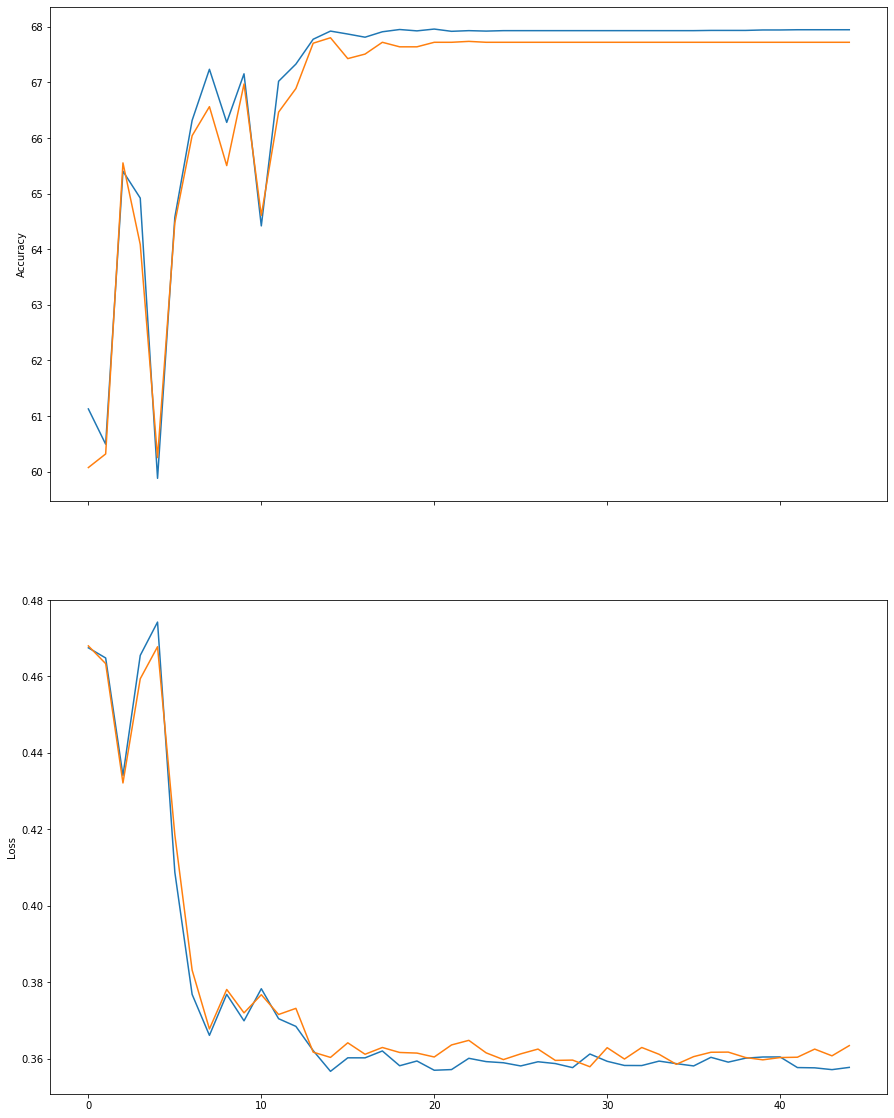

In [21]:
# Jigsaw initialization - 10/3 - Extension
model_state_dict = torch.load('/beegfs/sc6957/capstone/models/20191106/snet2_jigsaw_large_best_model.pth')['modelStateDict']

run_model(model=AudioConvNet(fc=Identity()), model_state_dict=model_state_dict, lr=0.01, num_epochs=45, model_suffix='jigsaw_10_3_ext_best')

Epoch:1, Validation Accuracy:34.88, Training Acc: 35.03, Val Loss: 1.70538, Train Loss: 1.67405
Epoch:2, Validation Accuracy:41.89, Training Acc: 41.58, Val Loss: 1.40111, Train Loss: 1.38658
Epoch:3, Validation Accuracy:41.14, Training Acc: 40.73, Val Loss: 1.26763, Train Loss: 1.27080
Epoch:4, Validation Accuracy:42.85, Training Acc: 42.78, Val Loss: 1.28681, Train Loss: 1.26315
Epoch:5, Validation Accuracy:39.19, Training Acc: 38.83, Val Loss: 1.57345, Train Loss: 1.59087
Epoch:6, Validation Accuracy:44.59, Training Acc: 44.28, Val Loss: 1.30493, Train Loss: 1.30666
Epoch:7, Validation Accuracy:41.59, Training Acc: 41.34, Val Loss: 1.19198, Train Loss: 1.19545
Epoch:8, Validation Accuracy:38.73, Training Acc: 38.36, Val Loss: 1.46830, Train Loss: 1.45555
Epoch     8: reducing learning rate of group 0 to 1.0000e-03.
Epoch:9, Validation Accuracy:42.85, Training Acc: 42.61, Val Loss: 1.27393, Train Loss: 1.26335
Epoch:10, Validation Accuracy:47.76, Training Acc: 47.26, Val Loss: 0.9506

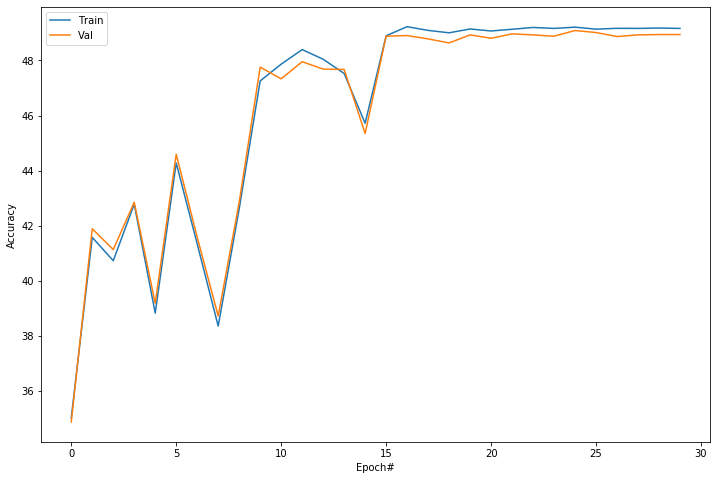

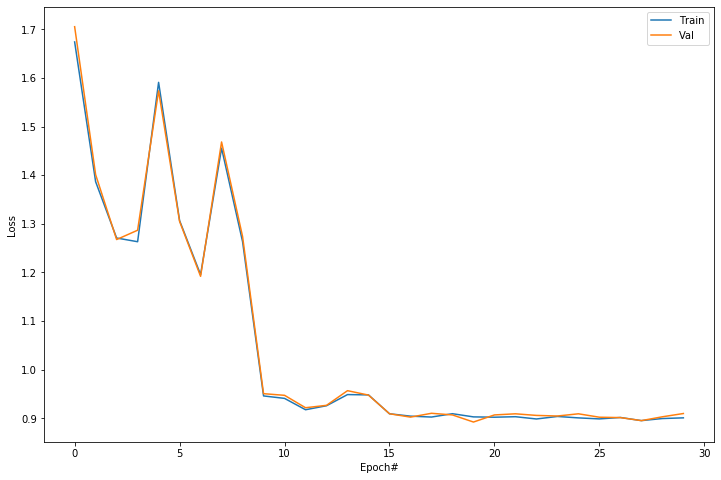

In [13]:
# TimeReversal initialization 
model_state_dict = torch.load('/beegfs/bva212/capstone/new_model/checkpoint_model.pth')['bestModelStateDict']
        
run_model(model_state_dict=model_state_dict, lr=0.01, num_epochs=30, model_suffix='time_reversal_chkpnt_15')

Epoch:1, Validation Accuracy:40.94, Training Acc: 40.55, Val Loss: 1.35276, Train Loss: 1.35066
Epoch:2, Validation Accuracy:42.20, Training Acc: 41.94, Val Loss: 1.31838, Train Loss: 1.36212
Epoch:3, Validation Accuracy:42.96, Training Acc: 42.80, Val Loss: 1.39984, Train Loss: 1.39039
Epoch:4, Validation Accuracy:42.24, Training Acc: 41.21, Val Loss: 1.17581, Train Loss: 1.18159
Epoch:5, Validation Accuracy:38.50, Training Acc: 38.59, Val Loss: 1.41338, Train Loss: 1.39981
Epoch     5: reducing learning rate of group 0 to 1.0000e-03.
Epoch:6, Validation Accuracy:40.80, Training Acc: 39.72, Val Loss: 1.25061, Train Loss: 1.25380
Epoch:7, Validation Accuracy:44.92, Training Acc: 45.42, Val Loss: 0.96885, Train Loss: 0.97465
Epoch:8, Validation Accuracy:48.43, Training Acc: 48.26, Val Loss: 0.92236, Train Loss: 0.92855
Epoch:9, Validation Accuracy:46.98, Training Acc: 46.54, Val Loss: 0.94105, Train Loss: 0.93303
Epoch:10, Validation Accuracy:47.78, Training Acc: 47.91, Val Loss: 0.9695

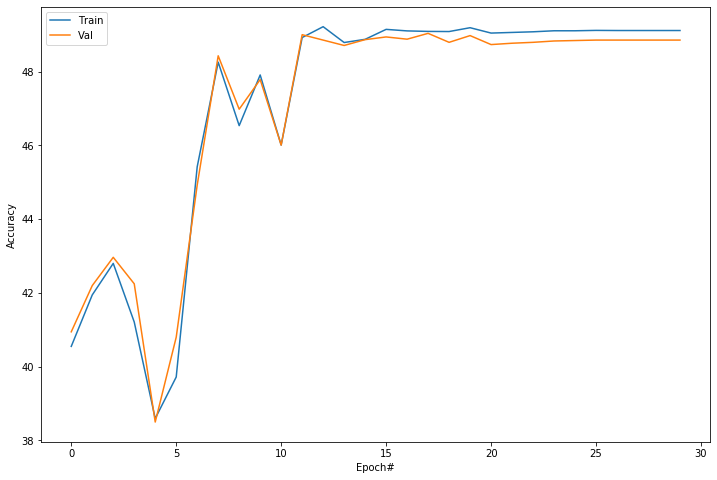

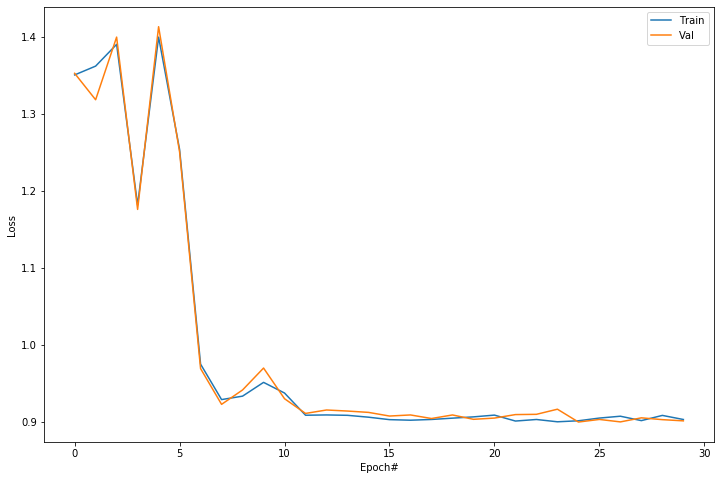

In [14]:
# TimeReversal initialization 
model_state_dict = torch.load('/beegfs/bva212/capstone/new_model/best_model.pth')['modelStateDict']
        
run_model(model_state_dict=model_state_dict, lr=0.01, num_epochs=30, model_suffix='time_reversal_best')

/home/jk6373/pyenv/ssml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 1
Training - Accuracy: 61.67, Loss: 0.49288, F1: 0.62
Validation - Accuracy: 62.37, Loss: 0.49014, F1: 0.62
Epoch: 2
Training - Accuracy: 55.85, Loss: 0.47499, F1: 0.56
Validation - Accuracy: 56.00, Loss: 0.47921, F1: 0.56
Epoch: 3
Training - Accuracy: 60.62, Loss: 0.43011, F1: 0.61
Validation - Accuracy: 61.27, Loss: 0.43914, F1: 0.61
Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 4
Training - Accuracy: 59.25, Loss: 0.50375, F1: 0.59
Validation - Accuracy: 57.73, Loss: 0.52708, F1: 0.58
Epoch: 5
Training - Accuracy: 65.12, Loss: 0.37921, F1: 0.65
Validation - Accuracy: 65.62, Loss: 0.37746, F1: 0.66
Epoch: 6
Training - Accuracy: 64.59, Loss: 0.38555, F1: 0.65
Validation - Accuracy: 64.15, Loss: 0.38488, F1: 0.64
Epoch: 7
Training - Accuracy: 66.08, Loss: 0.38290, F1: 0.66
Validation - Accuracy: 66.16, Loss: 0.37960, F1: 0.66
Epoch: 8
Training - Accuracy: 65.89, Loss: 0.37885, F1: 0.66
Validation - Accuracy: 66.06, Loss: 0.38102, F1: 0.66
Epoch: 9
Training 

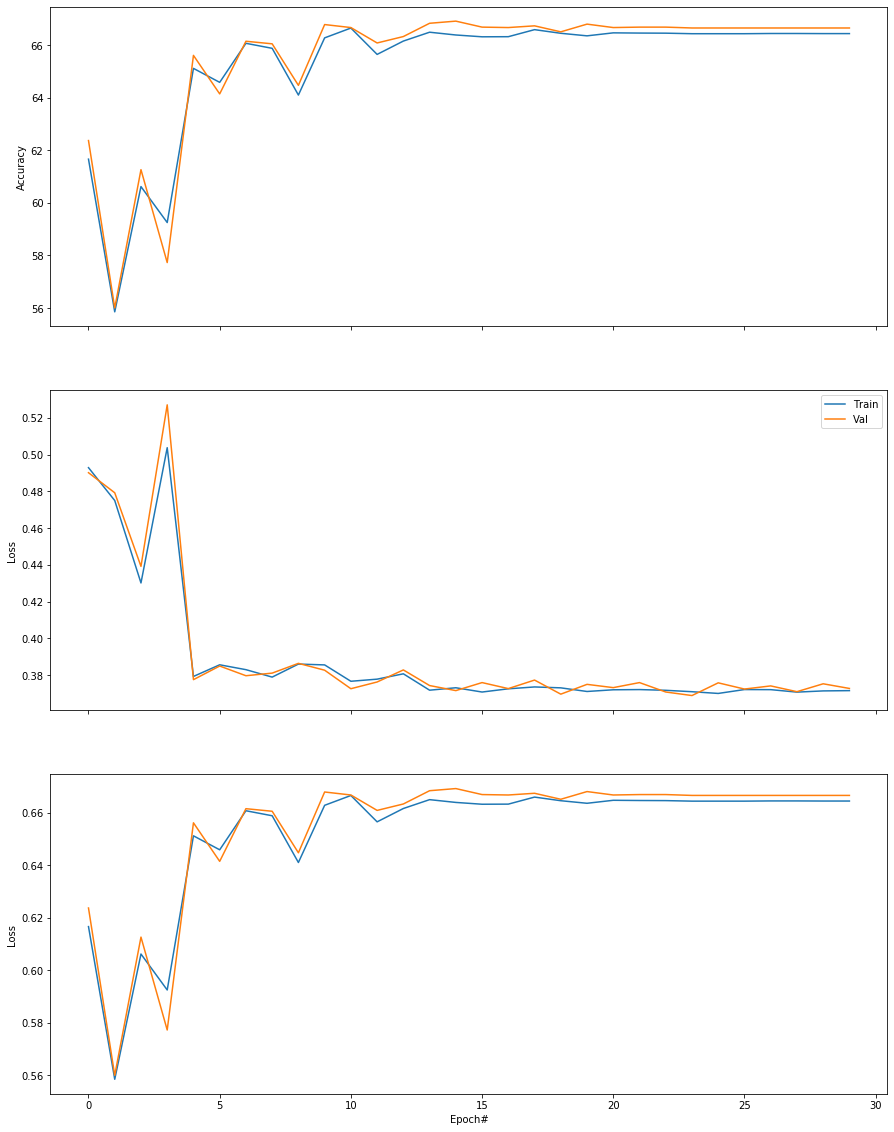

In [15]:
# Jigsaw initialization - 3/1 - Extension
model_state_dict = torch.load('/beegfs/sc6957/capstone/models/20191116/snet2_jigsaw_large_best_model.pth')['modelStateDict']

run_model(model=AudioConvNet(fc=Identity()), model_state_dict=model_state_dict, lr=0.01, num_epochs=30, model_suffix='jigsaw_3_1_ext_best')

Epoch:1, Validation Accuracy:35.50, Training Acc: 35.68, Val Loss: 1.92858, Train Loss: 1.91335
Epoch:2, Validation Accuracy:38.74, Training Acc: 39.05, Val Loss: 1.54965, Train Loss: 1.53195
Epoch:3, Validation Accuracy:38.67, Training Acc: 38.58, Val Loss: 1.34661, Train Loss: 1.34186
Epoch:4, Validation Accuracy:42.03, Training Acc: 41.70, Val Loss: 1.55276, Train Loss: 1.53218
Epoch:5, Validation Accuracy:36.55, Training Acc: 36.34, Val Loss: 1.60372, Train Loss: 1.64066
Epoch:6, Validation Accuracy:39.75, Training Acc: 39.93, Val Loss: 1.60260, Train Loss: 1.58803
Epoch:7, Validation Accuracy:44.25, Training Acc: 44.70, Val Loss: 1.53051, Train Loss: 1.51780
Epoch:8, Validation Accuracy:41.87, Training Acc: 42.35, Val Loss: 1.67718, Train Loss: 1.63273
Epoch:9, Validation Accuracy:45.18, Training Acc: 44.54, Val Loss: 1.50275, Train Loss: 1.46676
Epoch:10, Validation Accuracy:44.30, Training Acc: 44.45, Val Loss: 1.58614, Train Loss: 1.56705
Epoch:11, Validation Accuracy:43.85, Tr

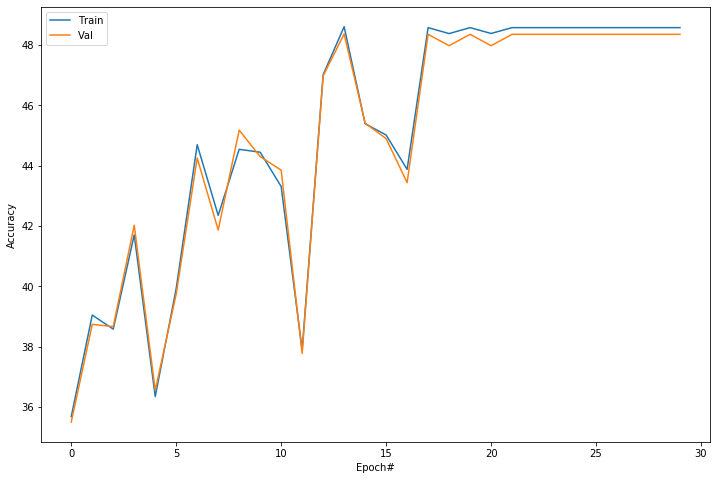

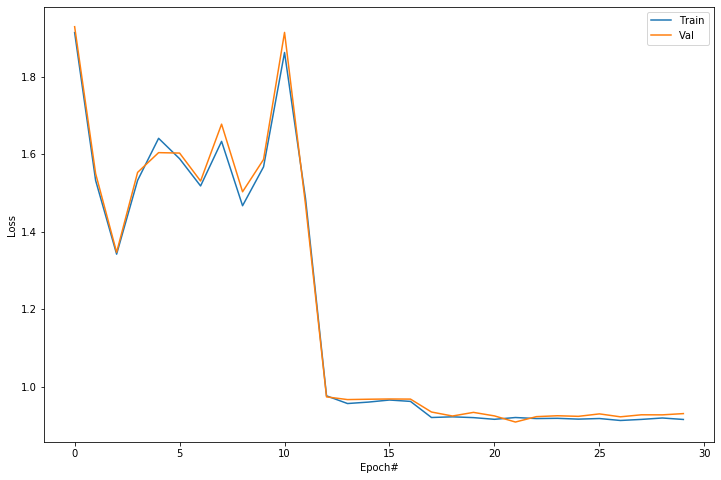

In [16]:
# Jigsaw initialization - 3/1
model_state_dict = torch.load('/beegfs/sc6957/capstone/models/20191116/snet3_jigsaw_large_best_model.pth')['modelStateDict']

run_model(model_state_dict=model_state_dict, lr=0.01, num_epochs=30, model_suffix='jigsaw_3_1_best')

In [20]:
model_file_path = './model/complete_dataset/downstream_frozen*'
results = {}
for model_file in glob(model_file_path):
    model_dict = torch.load(model_file)
    model_state_dict = model_dict['model_state_dict']
    model = AudioConvNet(fc=Identity())
    model.fc = SimpleMLP_Model()
    model.load_state_dict(model_state_dict)
    model.to(device)
    results_key = os.path.basename(model_file)[len('downstream_frozen_'):]
    results[results_key] = {}
    val_acc = np.array(model_dict['val_acc_list'])
    max_val_acc = max(val_acc)
    results[results_key]['val'] = (max_val_acc,  model_dict['val_loss_list'][np.where(val_acc == max_val_acc)[0][0]])
    results[results_key]['test'] = test_model(Test_loader, model)
 

key_order_map = {1: 'random_init', 2: 'jigsaw_10_3_wfc_chkpnt_5', 3: 'jigsaw_10_3_wfc_best', 4: 'jigsaw_3_1_wfc_best', 5: 'jigsaw_3_1_best', \
                             6: 'time_reversal_chkpnt_15', 7: 'time_reversal_best'}
model_test_results = OrderedDict((value, results[value]) for key, value in sorted(key_order_map.items()))
model_test_results

OrderedDict([('random_init',
              {'val': (51.381348775485584, 0.8640778256058693),
               'test': (68.62885857860732,
                0.8861826708316803,
                {'accordion': {'0.0': {'precision': 0.7835051546391752,
                   'recall': 1.0,
                   'f1-score': 0.8786127167630058,
                   'support': 152},
                  '1.0': {'precision': 0.0,
                   'recall': 0.0,
                   'f1-score': 0.0,
                   'support': 42},
                  'accuracy': 0.7835051546391752,
                  'macro avg': {'precision': 0.3917525773195876,
                   'recall': 0.5,
                   'f1-score': 0.4393063583815029,
                   'support': 194},
                  'weighted avg': {'precision': 0.6138803273461579,
                   'recall': 0.7835051546391752,
                   'f1-score': 0.6883975925153448,
                   'support': 194}},
                 'banjo': {'0.0': {'precision

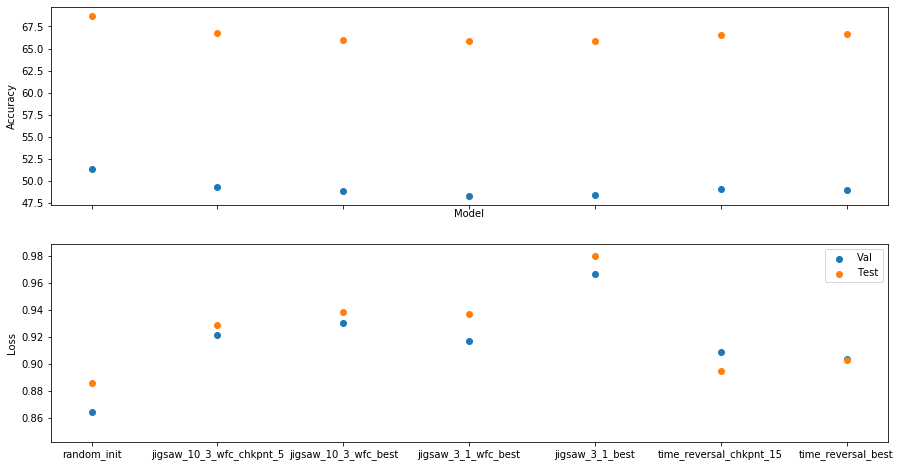

In [21]:
x = range(len(model_test_results))
key_list = list(model_test_results.keys())
values = np.array(list(model_test_results.values()))

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 8), sharex=True)

ax[0].scatter(x, [value['val'][0] for value in values], label='Val')
ax[0].scatter(x, [value['test'][0] for value in values], label='Test')
ax[0].set_ylabel('Accuracy')
ax[1].scatter(x, [value['val'][1] for value in values], label='Val')
ax[1].scatter(x, [value['test'][1] for value in values], label='Test')
ax[1].set_ylabel('Loss')

ax[0].set_xticks(x)    
ax[0].set_xticklabels(key_list, rotation=30)
ax[0].set_xlabel('Model')
# ax[0].legend(loc='best')
ax[1].legend(loc='best')

plt.show()

In [7]:
!sh call_analysis_code.sh

Submitted batch job 5827458
Submitted batch job 5827459
Submitted batch job 5827460
Submitted batch job 5827461
Submitted batch job 5827462
Submitted batch job 5827463
Submitted batch job 5827464


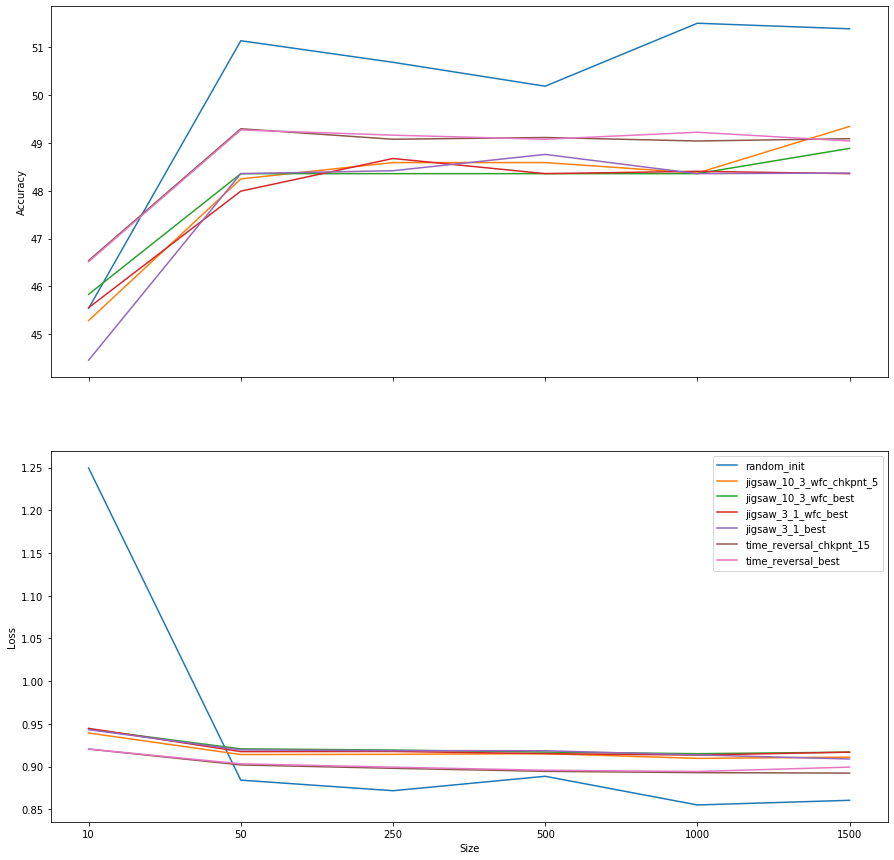

In [25]:
model_file_path = './model/limited_dataset/'
key_order_map = {1: 'random_init', 2: 'jigsaw_10_3_wfc_chkpnt_5', 3: 'jigsaw_10_3_wfc_best', 4: 'jigsaw_3_1_wfc_best', 5: 'jigsaw_3_1_best', \
                             6: 'time_reversal_chkpnt_15', 7: 'time_reversal_best'}
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 15), sharex=True)
for _, kvalue in sorted(key_order_map.items()):
    results = pickle.load(open(model_file_path+kvalue+'_trng_data_size_results.pkl', 'rb'))
    x = range(len(results))
    key_list = list(results.keys())
    values = np.array(list(results.values()))

    ax[0].plot([max(value['val_acc_list']) for value in values], label=kvalue)
    # ax[0].scatter(x, [value['test'][0] for value in values], label='Test')
    ax[0].set_ylabel('Accuracy')
    ax[1].plot([min(value['val_loss_list']) for value in values], label=kvalue)
    # ax[1].scatter(x, [value['test'][1] for value in values], label='Test')
    ax[1].set_ylabel('Loss')

    ax[1].set_xticks(x)    
    ax[1].set_xticklabels(key_list)
    ax[1].set_xlabel('Size')
#     ax[0].legend(loc='best')
    ax[1].legend(loc='best')

plt.show()

In [13]:
r3 = re.compile('fc')

def run_resnet(model_state_dict, lr, num_epochs, model_suffix):
    
    # Prepare/load model
    model = resnet18
    model.fc = Identity()
    
    if model_state_dict is not None: 
        for key in list(model_state_dict.keys()):
            cs = r3.search(key)
            if cs is None:
                model_state_dict[key[len('resnet.'):]] = model_state_dict[key]
                del model_state_dict[key]
            elif cs.start() != 0:
                del model_state_dict[key]
#     print(model, model.state_dict().keys())
        model.load_state_dict(model_state_dict)
    
    for m in model.modules():
            if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
        
    for param in model.parameters():
            param.requires_grad = False
            
    model.fc = SimpleMLP_Model()
#     print(model, model.state_dict())
    model.to(device)

    # Train
    optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad == True], lr=lr, weight_decay = 0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True, \
                                                           threshold=0.03, threshold_mode='abs', cooldown=0, min_lr=0, eps=1e-08)
    train_acc_list, train_loss_list, train_f1_list, best_train_class_wise_results, best_train_prt, \
                val_acc_list, val_loss_list, val_f1_list, best_val_class_wise_results, best_val_prt, best_model_state_dict = \
       train_model(Train_loader, Val_loader, model, optimizer, scheduler, num_epochs)
    
    file_path = '/home/jk6373/self_supervised_machine_listening/code/downstream/frozen/model/complete_dataset/'
    file_name = 'downstream_frozen_' + model_suffix
    torch.save({
        'train_acc_list': train_acc_list,
        'train_loss_list': train_loss_list,
        'train_f1_list': train_f1_list,
        'train_class_wise_results': best_train_class_wise_results,
        'train_prt': best_train_prt,
        'val_acc_list': val_acc_list,
        'val_loss_list': val_loss_list,
        'val_f1_list': train_f1_list,
        'val_class_wise_results': best_val_class_wise_results,
        'val_prt': best_val_prt,
        'model_state_dict': best_model_state_dict
        }, file_path+file_name)

    #Plot
#     fig = plt.figure()
#     fig.set_size_inches(12,8)
#     plt.plot(train_acc_list, label='Train')
#     plt.plot(val_acc_list, label='Val')
#     plt.xlabel('Epoch#')
#     plt.ylabel('Accuracy')
#     plt.legend(loc='best')
#     plt.show()
    
#     fig = plt.figure()
#     fig.set_size_inches(12,8)
#     plt.plot(train_loss_list, label='Train')
#     plt.plot(val_loss_list, label='Val')
#     plt.xlabel('Epoch#')
#     plt.ylabel('Loss')
#     plt.legend(loc='best')
#     plt.show()
    
#     x = range(len(results))
#     key_list = list(results.keys())
#     values = np.array(list(results.values()))

    fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (15, 15), sharex=True)

    ax[0].plot(train_acc_list, label='Train')
    ax[0].plot(val_acc_list, label='Val')
    ax[0].set_ylabel('Accuracy')
    ax[1].plot(train_loss_list, label='Train')
    ax[1].plot(val_loss_list, label='Val')
    ax[1].set_ylabel('Loss')
    ax[2].plot(train_f1_list, label='Train')
    ax[2].plot(val_f1_list, label='Val')
    ax[2].set_ylabel('F1')

#     ax[0].set_xticks(x)    
#     ax[0].set_xticklabels(key_list, rotation=30)
    ax[2].set_xlabel('Epoch#')
#     ax[0].legend(loc='best')
    ax[1].legend(loc='best')

    plt.show()

/home/jk6373/pyenv/ssml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch:1
Training - Accuracy: 62.45, Loss: 0.46730, F1: 0.62
Validation - Accuracy: 62.08, Loss: 0.45758, F1: 0.62
Epoch:2
Training - Accuracy: 63.86, Loss: 0.46010, F1: 0.64
Validation - Accuracy: 62.37, Loss: 0.47175, F1: 0.62
Epoch:3
Training - Accuracy: 63.55, Loss: 0.43882, F1: 0.64
Validation - Accuracy: 61.85, Loss: 0.46279, F1: 0.62
Epoch:4
Training - Accuracy: 58.92, Loss: 0.49577, F1: 0.59
Validation - Accuracy: 57.22, Loss: 0.51462, F1: 0.57
Epoch     4: reducing learning rate of group 0 to 1.0000e-03.
Epoch:5
Training - Accuracy: 61.69, Loss: 0.42636, F1: 0.62
Validation - Accuracy: 59.59, Loss: 0.45115, F1: 0.60
Epoch:6
Training - Accuracy: 69.71, Loss: 0.33998, F1: 0.70
Validation - Accuracy: 67.80, Loss: 0.36278, F1: 0.68
Epoch:7
Training - Accuracy: 70.61, Loss: 0.33703, F1: 0.71
Validation - Accuracy: 68.03, Loss: 0.36068, F1: 0.68
Epoch:8
Training - Accuracy: 70.58, Loss: 0.33684, F1: 0.71
Validation - Accuracy: 68.13, Loss: 0.36030, F1: 0.68
Epoch:9
Training - Accurac

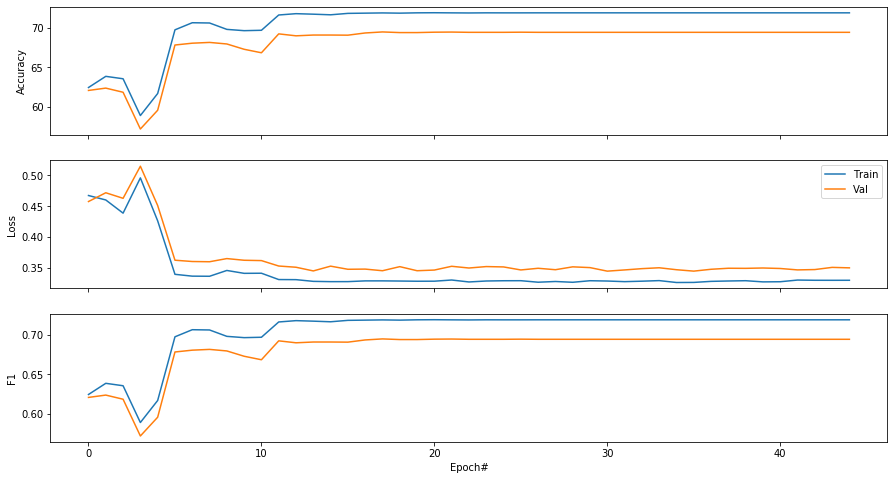

In [16]:
# Jigsaw initialization - ResNet - 10/3
model_state_dict = torch.load('/beegfs/sc6957/capstone/models/20191123/resnet_jigsaw_10_large_best_model.pth')['modelStateDict']

run_resnet(model_state_dict=model_state_dict, lr=0.01, num_epochs=45, model_suffix='jigsaw_10_3_resnet_best')

/home/jk6373/pyenv/ssml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 1
Training - Accuracy: 62.47, Loss: 0.43178, F1: 0.62
Validation - Accuracy: 61.48, Loss: 0.42653, F1: 0.61
Epoch: 2
Training - Accuracy: 66.58, Loss: 0.42633, F1: 0.67
Validation - Accuracy: 65.67, Loss: 0.43606, F1: 0.66
Epoch: 3
Training - Accuracy: 64.31, Loss: 0.42163, F1: 0.64
Validation - Accuracy: 62.67, Loss: 0.43793, F1: 0.63
Epoch: 4
Training - Accuracy: 63.02, Loss: 0.43883, F1: 0.63
Validation - Accuracy: 61.59, Loss: 0.45824, F1: 0.62
Epoch     4: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 5
Training - Accuracy: 60.56, Loss: 0.46187, F1: 0.61
Validation - Accuracy: 59.21, Loss: 0.48497, F1: 0.59
Epoch: 6
Training - Accuracy: 70.70, Loss: 0.33453, F1: 0.71
Validation - Accuracy: 69.24, Loss: 0.35453, F1: 0.69
Epoch: 7
Training - Accuracy: 70.43, Loss: 0.33373, F1: 0.70
Validation - Accuracy: 68.08, Loss: 0.35452, F1: 0.68
Epoch: 8
Training - Accuracy: 71.79, Loss: 0.32764, F1: 0.72
Validation - Accuracy: 69.94, Loss: 0.34863, F1: 0.70
Epoch: 9
Training 

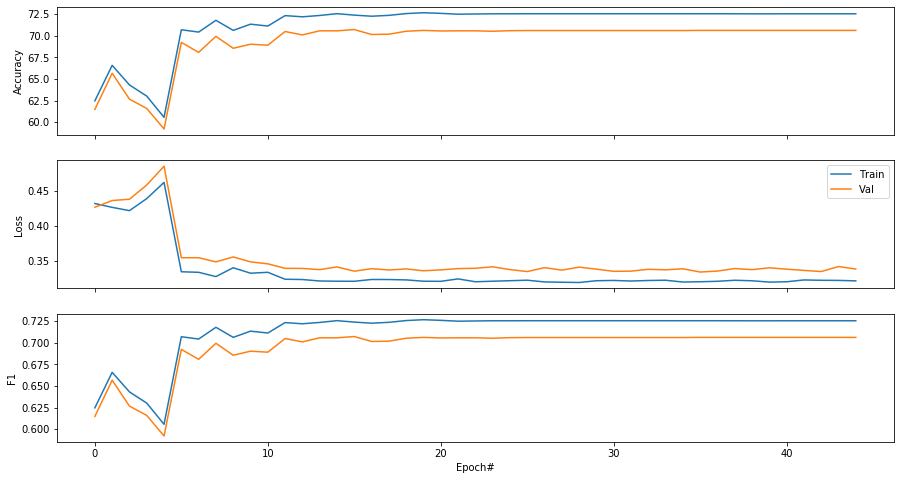

In [17]:
# Jigsaw initialization - ResNet - 3/1
model_state_dict = torch.load('/beegfs/sc6957/capstone/models/20191123/resnet_jigsaw_large_best_model.pth')['modelStateDict']

run_resnet(model_state_dict=model_state_dict, lr=0.01, num_epochs=45, model_suffix='jigsaw_3_1_resnet_best')

/home/jk6373/pyenv/ssml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 1
Training - Accuracy: 64.95, Loss: 3.61375, F1: 0.65
Validation - Accuracy: 63.76, Loss: 3.76916, F1: 0.64
Epoch: 2
Training - Accuracy: 65.48, Loss: 4.88925, F1: 0.65
Validation - Accuracy: 64.23, Loss: 4.98675, F1: 0.64
Epoch: 3
Training - Accuracy: 66.67, Loss: 3.09615, F1: 0.67
Validation - Accuracy: 64.74, Loss: 3.25144, F1: 0.65
Epoch: 4
Training - Accuracy: 61.08, Loss: 4.69071, F1: 0.61
Validation - Accuracy: 59.65, Loss: 4.90307, F1: 0.60
Epoch: 5
Training - Accuracy: 61.97, Loss: 4.32782, F1: 0.62
Validation - Accuracy: 60.12, Loss: 4.42096, F1: 0.60
Epoch     5: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 6
Training - Accuracy: 64.54, Loss: 3.28098, F1: 0.65
Validation - Accuracy: 62.13, Loss: 3.59083, F1: 0.62
Epoch: 7
Training - Accuracy: 72.68, Loss: 1.11455, F1: 0.73
Validation - Accuracy: 68.47, Loss: 1.31730, F1: 0.68
Epoch: 8
Training - Accuracy: 73.04, Loss: 0.96584, F1: 0.73
Validation - Accuracy: 68.88, Loss: 1.14496, F1: 0.69
Epoch: 9
Training 

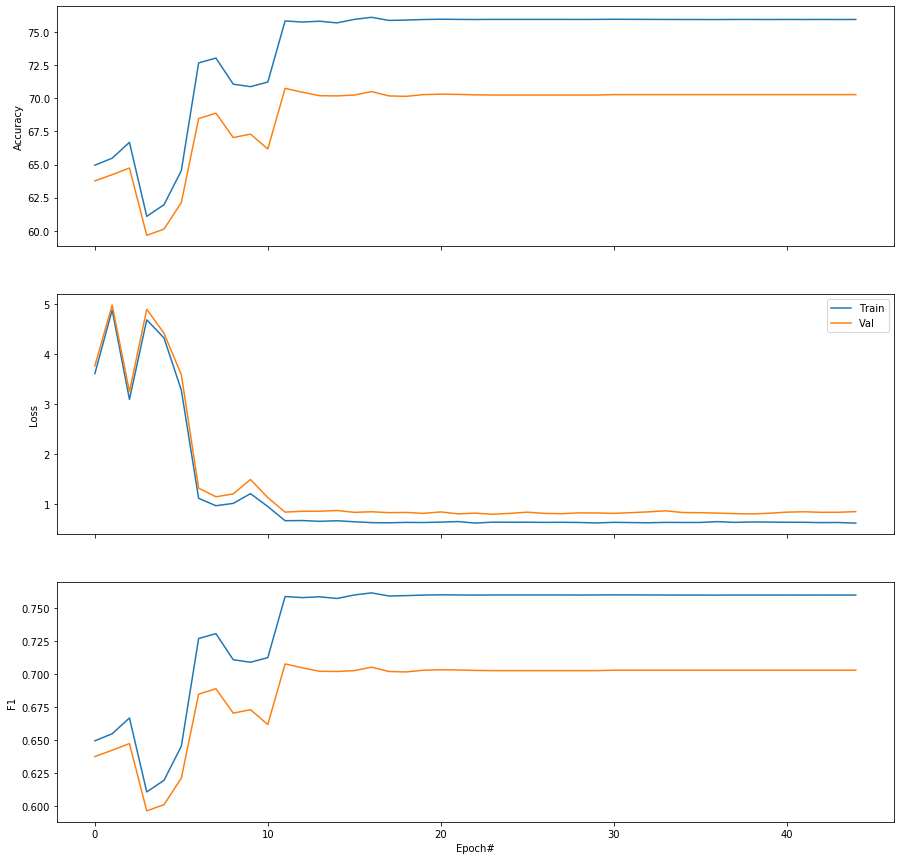

In [18]:
# Random initialization - ResNet
run_resnet(model_state_dict=None, lr=0.01, num_epochs=45, model_suffix='random_resnet_init')

In [24]:
model_file_prefix = './model/complete_dataset/downstream_frozen_'
model_suffix = 'jigsaw_10_3_ext_best'
model_dict = torch.load(model_file_prefix+model_suffix)
results_path = '../../../results/'

In [25]:
# Calculate test performance  & store results
model = AudioConvNet(fc=Identity())
model.fc = SimpleMLP_Model(in_ftr=256, out_ftr=20)
model.load_state_dict(model_dict['model_state_dict'])
model.to(device)

model_test_results = pickle.load(open(results_path+'complete_dataset_results.pkl','rb'))
# model_test_results = {}
model_test_results[model_suffix] = {}
# val_acc = np.array(model_dict['val_acc_list'])
# max_val_acc = max(val_acc)
# model_test_results[model_suffix]['val'] = (max_val_acc,  model_dict['val_loss_list'][np.where(val_acc == max_val_acc)[0][0]], \
#                                                                    model_dict['val_f1_list'][np.where(val_acc == max_val_acc)[0][0]], \
#                                                                 model_dict['val_class_wise_results'], model_dict['val_prt']
#                                                               )
model_test_results[model_suffix]['test'] = test_model(Test_loader, model)

In [26]:
model_test_results[model_suffix]['test']

(68.44706329595134,
 0.3562986703983333,
 0.6844706329595134,
 {'accordion': {'0.0': {'precision': 0.7862453531598513,
    'recall': 1.0,
    'f1-score': 0.8803329864724246,
    'support': 423},
   '1.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 115},
   'accuracy': 0.7862453531598513,
   'macro avg': {'precision': 0.39312267657992567,
    'recall': 0.5,
    'f1-score': 0.4401664932362123,
    'support': 538},
   'weighted avg': {'precision': 0.6181817553654594,
    'recall': 0.7862453531598513,
    'f1-score': 0.6921577198472781,
    'support': 538}},
  'banjo': {'0.0': {'precision': 0.7192982456140351,
    'recall': 0.9704142011834319,
    'f1-score': 0.8261964735516372,
    'support': 338},
   '1.0': {'precision': 0.5454545454545454,
    'recall': 0.08571428571428572,
    'f1-score': 0.14814814814814814,
    'support': 140},
   'accuracy': 0.7112970711297071,
   'macro avg': {'precision': 0.6323763955342903,
    'recall': 0.5280642434488588,
    'f1-score': 0.48

In [27]:
pickle.dump(model_test_results, open(results_path+'complete_dataset_results.pkl','wb'))